In [1]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib import colors
from matplotlib.colors import LogNorm
import matplotlib as mpl 
mpl.rcParams["image.origin"] = 'lower'
# mpl.rcParams["image.dpi"] = 200
import os
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import mplhep as hep
plt.style.use(hep.style.CMS)
#from plotting_utils import *
import uproot
import awkward as ak
#import dask.dataframe as dd
#from dask.distributed import Client

#client = Client(dashboard=True)

In [8]:
input_folder = "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/reco_comparison/overlapping_objects_studies/electrons_genmatching"
output_folder = "plots/electrons_gen_matching_v2"
os.makedirs(output_folder, exist_ok=True)

In [10]:
df_2 = pd.read_hdf(f"{input_folder}/Mustache_126X_mcRun3_2023_overlapping_v2.hdf5", start=0, stop=965985)
df_2.rename(columns={"output_object.csv":"genpart_index"}, inplace=True)
df_2 = df_2.iloc[:-1]

In [11]:
df_2.elematched = df_2.deltaR_genPart_ele < 0.7
df_2.phomatched = df_2.deltaR_genPart_pho < 0.7

In [12]:
incorrect_groups2 = []
group_sizes2 = df_2.groupby(['runId', 'eventId']).size()
        
for (runId, eventId), size in group_sizes2.iteritems():
    if size != 8:
        incorrect_groups2.append((runId, eventId))

if incorrect_groups2:
    print(f"Groups with size different from 8: {incorrect_groups2}")
'''    
for runId, eventId in incorrect_groups:
    specific_group = df_2i[(df_2i['runId'] == runId) & (df_2i['eventId'] == eventId)]
    print(f"Rows for group with runId {runId} and eventId {eventId}:\n{specific_group}\n")

'''
df_2filtered = df_2[~df_2[['runId', 'eventId']].apply(tuple, axis=1).isin(incorrect_groups2)]


/tmp/ipykernel_453/3344303549.py:4: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for (runId, eventId), size in group_sizes2.iteritems():


In [13]:
def calculate_deltaR(group):
    # Extract relevant columns
    group = group.sort_values(by='genpart_index')
    #print(group[['genpart_index','genpart_eta','genpart_phi']])
    eta = group['genpart_eta'].values
    phi = group['genpart_phi'].values
    
    
    et_gen = group['genpart_et'].values
    ele_et=group['ele_et'].values
    ele_index = group['ele_index'].values
    pho_index = group['pho_index'].values

    elematched = group['elematched'].values
    ele_nclsRefinedSC= group['ele_nclsRefinedSC'].values
    
    phomatched=group['phomatched'].values
    
    #new calo:
    calo_eta=group['calo_geneta'].values
    ele_eta=group['ele_eta'].values
    calo_phi=group['calo_genphi'].values
    ele_phi=group['ele_phi'].values
    calo_eta_diff1=calo_eta[::2]-ele_eta[::2]
    calo_eta_diff2=calo_eta[1::2]-ele_eta[1::2]
    calo_phi_diff1=calo_phi[::2]-ele_phi[::2]
    calo_phi_diff2=calo_phi[1::2]-ele_phi[1::2]
    deltaR_calo1=np.sqrt(calo_eta_diff1**2 + calo_phi_diff1**2)
    deltaR_calo2=np.sqrt(calo_eta_diff2**2 + calo_phi_diff2**2)
    
    eta_diff = -(eta[::2] - eta[1::2])
    dphi = -(phi[::2] - phi[1::2])
    dphi[dphi > np.pi] -= 2 * np.pi
    dphi[dphi < -np.pi] += 2 * np.pi
    dr_diff = np.sqrt(eta_diff**2 + dphi**2)
    eta_mean = (eta[::2] + eta[1::2]) / 2
    phi_mean = (phi[::2] + phi[1::2]) / 2
    
    data = {
        'deltaR': dr_diff,
        'deltaR_calo1': deltaR_calo1,
        'deltaR_calo2': deltaR_calo2,
        'deltaEta_calo1':calo_eta_diff1,
        'deltaEta_calo2':calo_eta_diff2,
        'deltaPhi_calo1':calo_phi_diff1,
        'deltaPhi_calo2':calo_phi_diff2,
        'deltaEta':(eta_diff),
        'deltaPhi':(dphi),
        'eta_mean': eta_mean,
        'phi_mean': phi_mean,
        "calo_energy1": et_gen[::2],
        'calo_energy2': et_gen[1::2],
        'ele_et1':ele_et[::2],
        'ele_et2':ele_et[1::2],
        'ele_index1': ele_index[::2],
        'ele_index2': ele_index[1::2],
        'pho_index1': pho_index[::2],
        'pho_index2': pho_index[1::2],
        'ele_matched1': elematched[::2],
        'ele_matched2': elematched[1::2],
        'pho_matched1': phomatched[::2],
        'pho_matched2': phomatched[1::2],
        'ele_nclsRefinedSC1': ele_nclsRefinedSC[::2],
        'ele_nclsRefinedSC2': ele_nclsRefinedSC[1::2],
    }
    
    return pd.DataFrame(data)

In [14]:
grouped_deltas2 = df_2filtered.groupby(['runId', 'eventId']).apply(calculate_deltaR)
grouped_deltas2.to_csv('grouped_deltas2.csv', index=True)

# Event same ele_index

In [2]:
grouped_deltas = pd.read_csv('grouped_deltas2.csv')
energy_ratio = grouped_deltas['calo_energy1'] / grouped_deltas['calo_energy2']
energy_ratio[grouped_deltas['calo_energy1'] < grouped_deltas['calo_energy2']] = grouped_deltas['calo_energy2'] / grouped_deltas['calo_energy1']
grouped_deltas["energy_ratio"] = energy_ratio

In [3]:
grouped_deltas

,runId,eventId,Unnamed: 2,deltaR,deltaR_calo1,deltaR_calo2,deltaEta_calo1,deltaEta_calo2,deltaPhi_calo1,deltaPhi_calo2,...,ele_index2,pho_index1,pho_index2,ele_matched1,ele_matched2,pho_matched1,pho_matched2,ele_nclsRefinedSC1,ele_nclsRefinedSC2,energy_ratio
0,1.0,1.0,0,0.556688,0.001555,0.014359,-0.001555,-0.005736,-0.000005,0.013164,...,3.0,6.0,3.0,True,True,True,True,1.0,3.0,1.977452
1,1.0,1.0,1,0.320304,0.000502,0.000110,0.000375,-0.000106,-0.000334,0.000028,...,0.0,5.0,0.0,True,True,True,True,1.0,1.0,1.797266
2,1.0,1.0,2,0.375094,0.000365,0.000109,-0.000163,0.000033,-0.000326,0.000104,...,4.0,4.0,4.0,True,True,True,True,1.0,1.0,52.527998
3,1.0,1.0,3,0.335604,0.000605,0.008537,0.000082,-0.000338,-0.000600,-0.008530,...,2.0,1.0,2.0,True,True,True,True,1.0,1.0,1.117792
4,1.0,2.0,0,0.119264,0.001249,0.004575,-0.001183,0.000740,0.000401,0.004515,...,6.0,1.0,6.0,True,True,True,True,1.0,2.0,2.628390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482987,4595.0,47.0,3,0.237472,0.005345,0.000422,-0.000092,-0.000390,-0.005344,0.000162,...,1.0,6.0,1.0,True,True,True,True,3.0,1.0,32.880573
482988,4595.0,48.0,0,0.530128,0.002926,0.001125,-0.000622,-0.000989,0.002859,0.000535,...,5.0,3.0,5.0,True,True,True,True,1.0,1.0,1.512006
482989,4595.0,48.0,1,0.622441,0.000116,0.000089,-0.000111,-0.000071,-0.000033,-0.000054,...,0.0,4.0,0.0,True,True,True,True,1.0,1.0,1.662586
482990,4595.0,48.0,2,0.477178,0.000218,0.000697,0.000046,-0.000453,-0.000213,0.000530,...,1.0,7.0,1.0,True,True,True,True,1.0,3.0,8.309955


In [4]:
same_ele_index_mask = (grouped_deltas['ele_index1'] == grouped_deltas['ele_index2']) &(grouped_deltas.ele_matched2==True)&(grouped_deltas.ele_matched1==True)
different_ele_index_mask = (grouped_deltas['ele_index1'] != grouped_deltas['ele_index2'] )&(grouped_deltas.ele_matched2==True)&(grouped_deltas.ele_matched1==True)
same_ele_events = grouped_deltas[same_ele_index_mask]
different_ele_events = grouped_deltas[different_ele_index_mask]
onemissing_events_mask =  ( (grouped_deltas.ele_matched1==False)&(grouped_deltas.ele_matched2==True))|( (grouped_deltas.ele_matched2==False)&(grouped_deltas.ele_matched1==True))
onemissing_events = grouped_deltas[onemissing_events_mask]

print(same_ele_events)
print(onemissing_events)


         runId  eventId  Unnamed: 2    deltaR  deltaR_calo1  deltaR_calo2  \
8          1.0      3.0           0  0.396164      0.005905      0.391734   
11         1.0      3.0           3  0.121039      0.000230      0.000230   
14         1.0      4.0           2  0.408611      0.000771      0.409049   
15         1.0      4.0           3  0.664554      0.664530      0.000115   
20         1.0      6.0           0  0.057895      0.058393      0.000669   
...        ...      ...         ...       ...           ...           ...   
482970  4595.0     43.0           2  0.688145      0.688139      0.000037   
482971  4595.0     43.0           3  0.595962      0.595223      0.001051   
482975  4595.0     44.0           3  0.419725      0.000074      2.617377   
482980  4595.0     46.0           0  0.096985      0.000678      0.096331   
482984  4595.0     47.0           0  0.108707      0.000596      0.108343   

        deltaEta_calo1  deltaEta_calo2  deltaPhi_calo1  deltaPhi_calo2  ...

In [43]:
pho_false=(same_ele_events.pho_matched1==False)&(same_ele_events.pho_matched1==False)
print(len(same_ele_events[pho_false]))

737


In [6]:
print(f"% of windows with genpart1 matched to electron: {sum(grouped_deltas.ele_matched1 == True)/ len(grouped_deltas)*100:.3f}%")
print(f"% of windows with genpart2 matched to electron: {sum(grouped_deltas.ele_matched2 == True)/ len(grouped_deltas)*100:.3f}%")

% of windows with genpart1 matched to electron: 93.892%
% of windows with genpart2 matched to electron: 93.883%


In [7]:
max_energy1 = (same_ele_events['calo_energy2']).max()
min_energy1 = same_ele_events['calo_energy2'].min()

# Print the maximum and minimum values
print("Maximum energy1:", max_energy1)
print("Minimum energy1:", min_energy1)

Maximum energy1: 499.99522638961696
Minimum energy1: 1.000678652318297


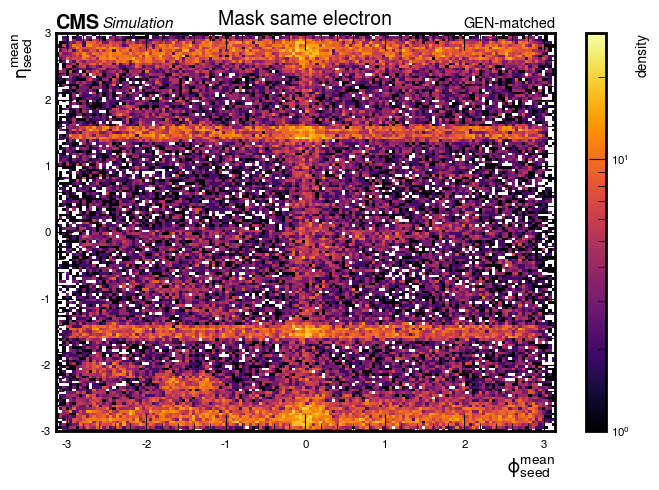

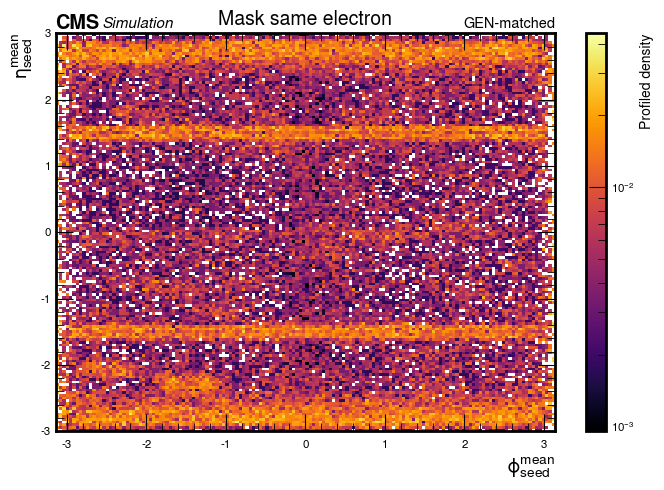

In [8]:
fig, ax = plt.subplots(1,1,dpi=100, figsize=(7, 5))

A,xedges,yedges  = np.histogram2d(same_ele_events.phi_mean ,same_ele_events.eta_mean,bins=(150, 150), range=((-np.pi,np.pi),(-3,3)))

s = 1#np.expand_dims(np.sum(A, axis=-1), axis=1)
a = A/s
X, Y = np.meshgrid(xedges, yedges)
I = ax.pcolormesh(X, Y, a.T, norm=LogNorm(), cmap="inferno")

fig.colorbar(I, ax=ax, label="density")
ax.set_ylabel("$\eta^{mean}_{seed}$", fontsize=14)
ax.set_xlabel("$\phi^{mean}_{seed}$", fontsize=14)
plt.title('Mask same electron',fontsize=14)
hep.cms.label(llabel="Simulation", rlabel="GEN-matched", loc=0, ax=ax,fontsize=11)
plt.tight_layout()
#plt.savefig('plots/eta_phi.png')
plt.show()
fig, ax = plt.subplots(1,1,dpi=100, figsize=(7, 5))

A,xedges,yedges  = np.histogram2d(same_ele_events.phi_mean ,same_ele_events.eta_mean,bins=(150, 150), range=((-np.pi,np.pi),(-3,3)))

s = np.expand_dims(np.sum(A, axis=-1), axis=1)
a = A/s
X, Y = np.meshgrid(xedges, yedges)
I = ax.pcolormesh(X, Y, a.T, norm=LogNorm(), cmap="inferno")

fig.colorbar(I, ax=ax, label="Profiled density")
ax.set_ylabel("$\eta^{mean}_{seed}$", fontsize=14)
ax.set_xlabel("$\phi^{mean}_{seed}$", fontsize=14)
plt.title('Mask same electron',fontsize=14)
hep.cms.label(llabel="Simulation", rlabel="GEN-matched", loc=0, ax=ax,fontsize=11)
plt.tight_layout()
#plt.savefig('plots/eta_phi_prof.png')


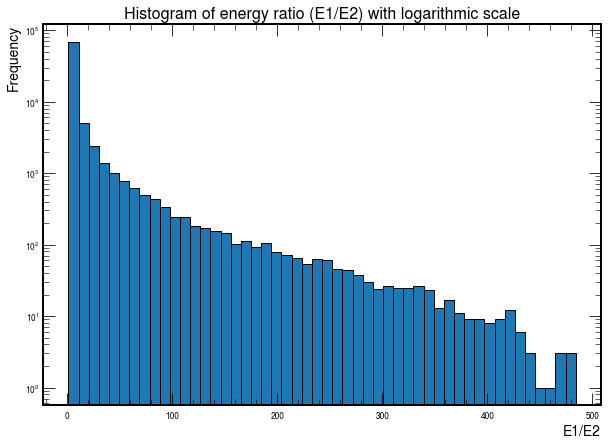

min energyratio:  1.0000209711428072


In [9]:
energy_ratio = same_ele_events['calo_energy1'] / same_ele_events['calo_energy2']
energy_ratio[same_ele_events['calo_energy1'] < same_ele_events['calo_energy2']] = same_ele_events['calo_energy2'] / same_ele_events['calo_energy1']

plt.subplots(figsize=(10,7))
plt.hist(energy_ratio, bins=50, edgecolor='black', log=True)  # Set log=True
plt.xlabel('E1/E2', fontsize=14)  # Increase fontsize for x-label
plt.ylabel('Frequency', fontsize=14)  # Increase fontsize for y-label
plt.title('Histogram of energy ratio (E1/E2) with logarithmic scale', fontsize=16)  # Increase fontsize for title
#plt.savefig('plots/hist_e1-e2.png')
plt.show()
print('min energyratio: ', energy_ratio.min())

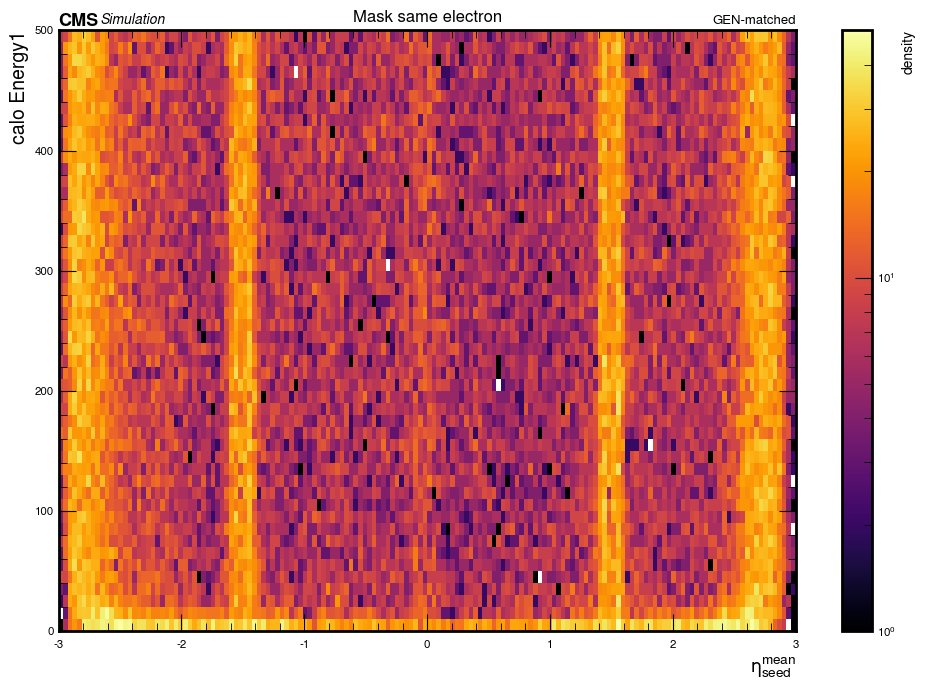

In [10]:
fig, ax = plt.subplots(1,1,dpi=100, figsize=(10, 7))

A,xedges,yedges  = np.histogram2d(same_ele_events.eta_mean ,same_ele_events.calo_energy1,bins=(160, 50), range=((-3,3),(0,500)))

s = 1 #np.expand_dims(np.sum(A, axis=-1), axis=1)
a = A
X, Y = np.meshgrid(xedges, yedges)
I = ax.pcolormesh(X, Y, a.T, norm=LogNorm(), cmap="inferno")

fig.colorbar(I, ax=ax, label="density")
ax.set_xlabel("$\eta^{mean}_{seed}$", fontsize=14)
ax.set_ylabel("calo Energy1", fontsize=14)
plt.title('Mask same electron')
hep.cms.label(llabel="Simulation", rlabel="GEN-matched", loc=0, ax=ax)
plt.tight_layout()
#plt.savefig('plots/e1_eta.png')

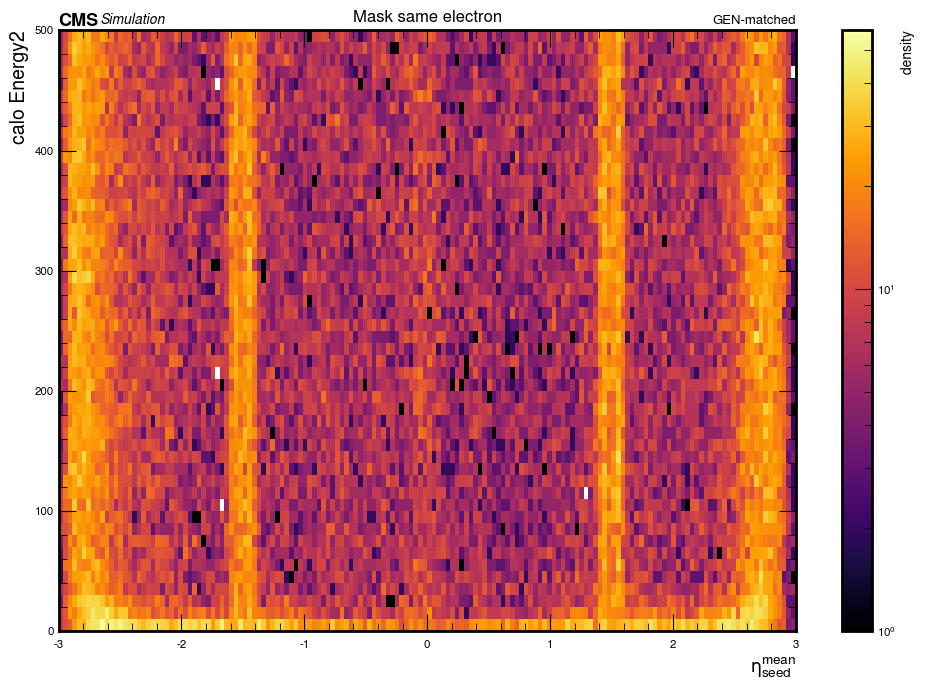

In [11]:
fig, ax = plt.subplots(1,1,dpi=100, figsize=(10, 7))

A,xedges,yedges  = np.histogram2d(same_ele_events.eta_mean ,same_ele_events.calo_energy2,bins=(160, 50), range=((-3,3),(0,500)))

s = 1#np.expand_dims(np.sum(A, axis=-1), axis=1)
a = A/s
X, Y = np.meshgrid(xedges, yedges)
I = ax.pcolormesh(X, Y, a.T, norm=LogNorm(), cmap="inferno")

fig.colorbar(I, ax=ax, label=" density")
ax.set_xlabel("$\eta^{mean}_{seed}$", fontsize=14)
ax.set_ylabel("calo Energy2", fontsize=14)
plt.title('Mask same electron')
hep.cms.label(llabel="Simulation", rlabel="GEN-matched", loc=0, ax=ax)
plt.tight_layout()
#plt.savefig('plots/e2_eta.png')

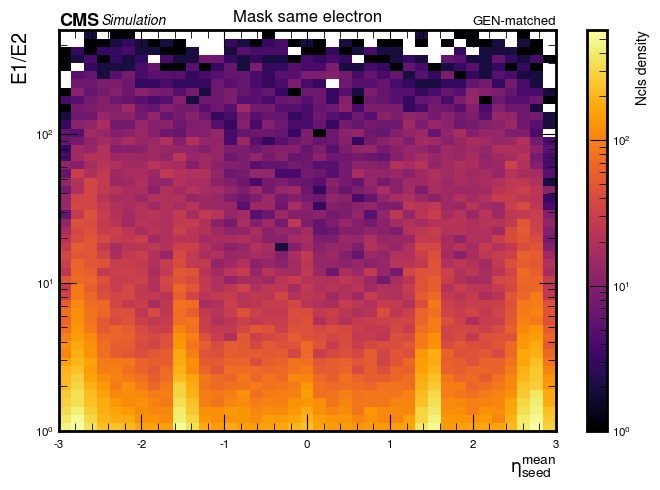

In [12]:
fig, ax = plt.subplots(1,1,dpi=100, figsize=(7, 5))

A,xedges,yedges  = np.histogram2d(same_ele_events.eta_mean ,energy_ratio, 
                                  bins=[
                                      np.linspace(-3,3,40), np.logspace(0, np.log10(500), 50, base=10)
                                  ])

s = 1#np.expand_dims(np.sum(A, axis=-1), axis=1)
a = A/s
X, Y = np.meshgrid(xedges, yedges)
I = ax.pcolormesh(X, Y, a.T, norm=LogNorm(), cmap="inferno")

fig.colorbar(I, ax=ax, label="Ncls density")
ax.set_xlabel("$\eta^{mean}_{seed}$", fontsize=14)
ax.set_ylabel("E1/E2", fontsize=14)
plt.title('Mask same electron')
ax.set_yscale("log")
hep.cms.label(llabel="Simulation", rlabel="GEN-matched", loc=0, ax=ax)
plt.tight_layout()
#plt.savefig('plots/e1-e2_eta.png')

# Delta R study

In [16]:
total_events = len(grouped_deltas)

same_ele_index_events = grouped_deltas[grouped_deltas['ele_index1'] == grouped_deltas['ele_index2']]
same_ele_index_count = len(same_ele_index_events)
percentage_same_ele_index = (same_ele_index_count / total_events) * 100

print(f"Percentage of events with the same ele_index: {percentage_same_ele_index:.2f}%")

Percentage of events with the same ele_index: 23.01%


In [17]:
eta_mean_range = (1.4, 1.6)

filtered_events = grouped_deltas[(grouped_deltas['eta_mean'] >= eta_mean_range[0]) & 
                                 (grouped_deltas['eta_mean'] <= eta_mean_range[1]) &
                                 (grouped_deltas['ele_index1'] == grouped_deltas['ele_index2'])]
total_events_eta_range = len(grouped_deltas[(grouped_deltas['eta_mean'] >= eta_mean_range[0]) & 
                                             (grouped_deltas['eta_mean'] <= eta_mean_range[1])])
same_ele_eta_range_count = len(filtered_events)
percentage_same_ele_index_eta_range = (same_ele_eta_range_count / total_events_eta_range) * 100

print(f"Percentage of events with the same ele_index in the range eta {eta_mean_range}: {percentage_same_ele_index_eta_range:.2f}%")

Percentage of events with the same ele_index in the range eta (1.4, 1.6): 41.42%


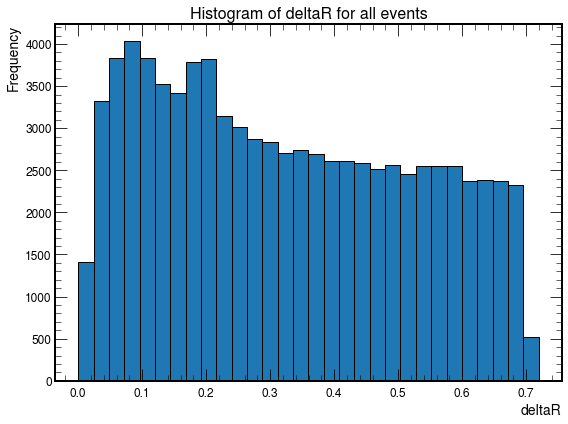

In [18]:
plt.figure(figsize=(8, 6))  
plt.hist(same_ele_events['deltaR'], bins=30, edgecolor='black')
plt.xlabel('deltaR', fontsize=14)  
plt.ylabel('Frequency', fontsize=14)  
plt.title('Histogram of deltaR for all events', fontsize=16)  
plt.xticks(fontsize=12) 
plt.yticks(fontsize=12) 
plt.tight_layout() 
plt.savefig('plots/deltaR_histogram.png')
plt.show()

In [19]:
print('delta r max: ',same_ele_events['deltaR'].max())

delta r max:  0.719442461754074


## Matched to the same Electron

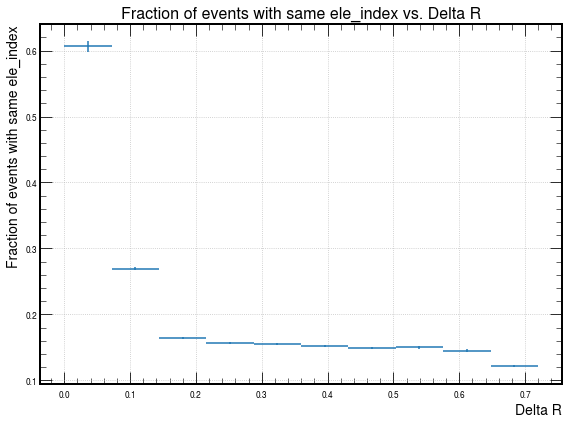

In [21]:
def fraction_same_ele_index_vs_deltaR(num_intervals):
    deltaR_max = same_ele_events['deltaR'].max()
    deltaR_values, y = np.linspace(0, deltaR_max, num_intervals + 1, retstep=True)

    fraction_list = []
    yer = []

    for i in range(len(deltaR_values) - 1):
        lower_bound = deltaR_values[i]
        upper_bound = deltaR_values[i + 1]
        #print('interval=[',lower_bound,upper_bound,']')
        mask = (same_ele_events['deltaR'] > lower_bound) & (same_ele_events['deltaR'] <= upper_bound)
        mask2 = (grouped_deltas['deltaR'] > lower_bound) & (grouped_deltas['deltaR'] <= upper_bound)

        n1 = len(same_ele_events[mask])
        #print('n1: ',n1)
        ntot = len(grouped_deltas[mask2])
        #print('ntot: ',ntot)
        if ntot == 0:
            ntot = 1
        fraction = n1 / ntot
        fraction_list.append(fraction)
        yer.append(np.sqrt(n1 + n1**2 / ntot) / ntot)

    plt.figure(figsize=(8,6))  # Larger figsize
    plt.errorbar(deltaR_values[:-1] + y / 2, fraction_list, xerr=np.ones(num_intervals) * y / 2, yerr=yer, fmt='none')
    #plt.scatter(deltaR_values[:-1] + y / 2, fraction_list)
    plt.xlabel('Delta R', fontsize=14)
    plt.ylabel('Fraction of events with same ele_index', fontsize=14) 
    plt.title('Fraction of events with same ele_index vs. Delta R', fontsize=16)  
    plt.grid(True)
    plt.tight_layout()
    #plt.savefig('plots/fraction_deltaR.png')
    plt.show()

num_intervals = 10
fraction_same_ele_index_vs_deltaR(num_intervals)


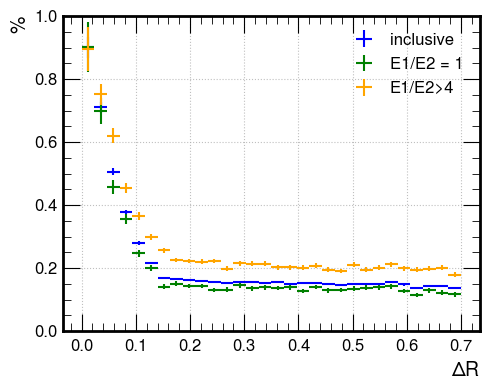

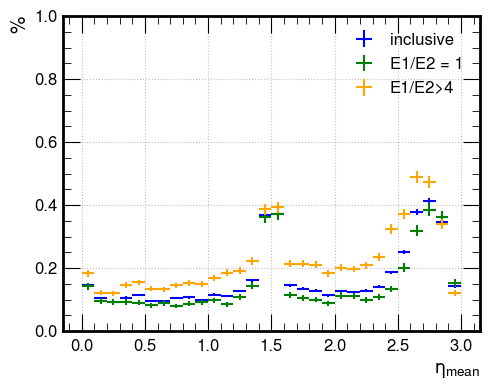

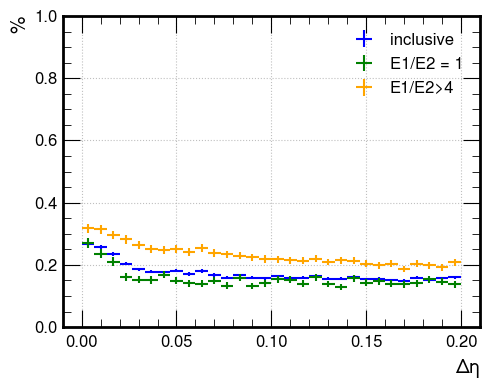

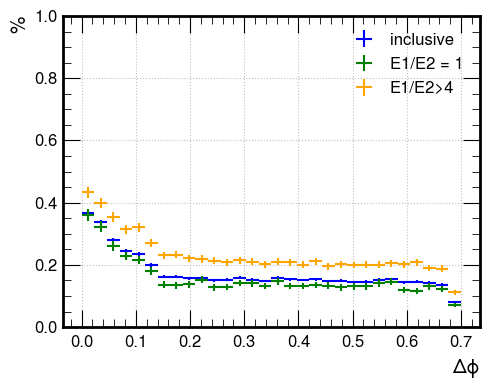

0.6995915174484253


In [22]:
mask_e1 =(energy_ratio>0.8)&(energy_ratio<1.2)
mask_e3 =energy_ratio>3

def fraction_same_ele_index_vs_deltaR(num_intervals,deltaR_max,col,xlab):
    #deltaR_max = 0.7
    deltaR_values, y = np.linspace(0, deltaR_max, num_intervals + 1, retstep=True)

    masks = [(1,1), 
             ((same_ele_events.energy_ratio > 0.8)&(same_ele_events.energy_ratio < 1.2),
              (grouped_deltas.energy_ratio > 0.8)&(grouped_deltas.energy_ratio < 1.2)),
             ((same_ele_events.energy_ratio > 4), (grouped_deltas.energy_ratio > 4))]

    names = ["inclusive", "E1/E2 = 1", "E1/E2>4"]
    colors= ["blue", "green", "orange"]
    plt.figure(figsize=(5,4), dpi=100)  # Larger figsize
    for (mask_same, mask_all), name, color in zip(masks, names, colors):
        
        fraction_list = []
        yer = []
    
        # mask_en_same = (same_ele_events.energy_ratio > 0.8)&(same_ele_events.energy_ratio > 1.2)
        # mask_en_same2 = (same_ele_events.energy_ratio > 3)
       #for mask_en in [True, mask_en_same, mask_en_same2)
        for i in range(len(deltaR_values) - 1):
            lower_bound = deltaR_values[i]
            upper_bound = deltaR_values[i + 1]
            #print('interval=[',lower_bound,upper_bound,']')
            mask = (same_ele_events[col] > lower_bound) & (same_ele_events[col] <= upper_bound) & mask_same
            mask2 = (grouped_deltas[col] > lower_bound) & (grouped_deltas[col] <= upper_bound) & mask_all
            
    
            n1 = len(same_ele_events[mask])
            #print('n1: ',n1)
            ntot = len(grouped_deltas[mask2])
            #print('ntot: ',ntot)
            if ntot == 0:
                ntot = 1
            fraction = n1 / ntot
            fraction_list.append(fraction)
            yer.append(np.sqrt(n1 + n1**2 / ntot) / ntot)
    
       
        plt.errorbar(deltaR_values[:-1] + y / 2, fraction_list, xerr=np.ones(num_intervals) * y / 2, yerr=yer, fmt='none',
                    label=name, c=color)
        #plt.scatter(deltaR_values[:-1] + y / 2, fraction_list)
    plt.xlabel(xlab,fontsize=14)
    plt.ylabel('%',fontsize=14) 
    plt.ylim(0, 1)
    #plt.title('Fraction of events with single electron matched for MSC', fontsize=16)  
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.grid(True)
    plt.tight_layout()
    
    plt.legend(fontsize=12)
    name='plotsM/sameele_'+col+'.pdf'
    plt.savefig(name)
    plt.show()

    
    
    


    
num_intervals = 30
fraction_same_ele_index_vs_deltaR(num_intervals,0.7, 'deltaR','$\Delta R$')
fraction_same_ele_index_vs_deltaR(num_intervals,3,'eta_mean','$\eta_{mean}$')
fraction_same_ele_index_vs_deltaR(num_intervals,0.2,'deltaEta','$\Delta \eta$')
fraction_same_ele_index_vs_deltaR(num_intervals,0.7,'deltaPhi','$\Delta \phi$')
print(same_ele_events['deltaPhi'].max())

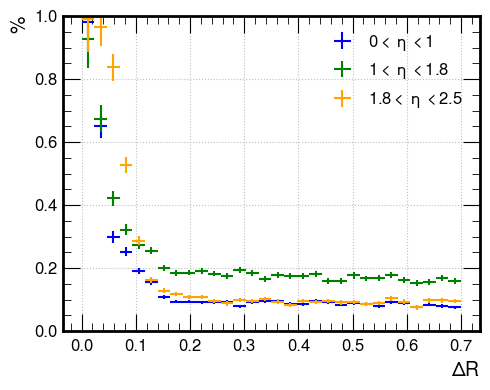

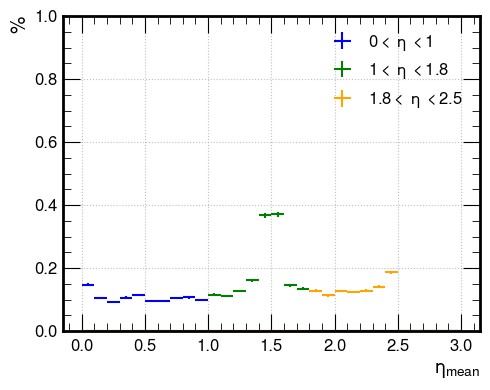

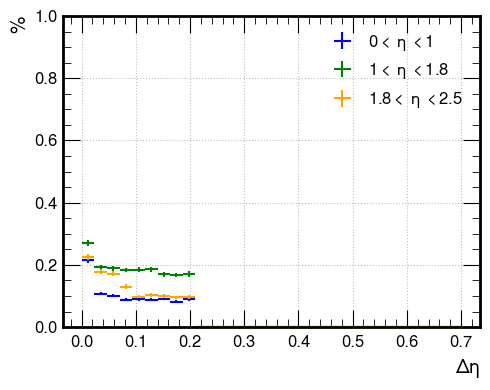

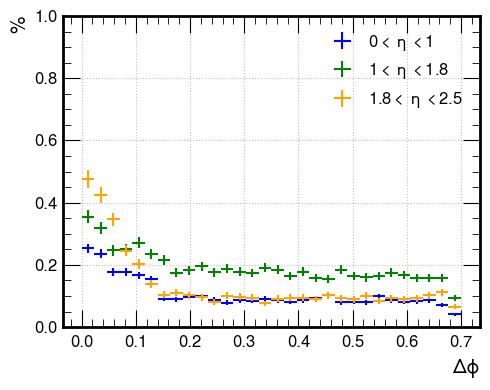

In [23]:
mask_e1 =(energy_ratio>0.8)&(energy_ratio<1.2)
mask_e3 =energy_ratio>3

def fraction_same_ele_index_vs_deltaR(num_intervals,deltaR_max,col , xlab):
    deltaR_values, y = np.linspace(0, deltaR_max, num_intervals + 1, retstep=True)
    mask_e1_g = (grouped_deltas.eta_mean<1)&(grouped_deltas.eta_mean>0)
    mask_e3_g =(grouped_deltas.eta_mean<1.8)&(grouped_deltas.eta_mean>1)
    mask_e0_g =(grouped_deltas.eta_mean<2.5)&(grouped_deltas.eta_mean>1.8)
    mask_e1 = (same_ele_events.eta_mean<1)&(same_ele_events.eta_mean>0)
    mask_e3 =(same_ele_events.eta_mean<1.8)&(same_ele_events.eta_mean>1)
    mask_e0 =(same_ele_events.eta_mean<2.5)&(same_ele_events.eta_mean>1.8)
    
    masks = [(mask_e1,mask_e1_g),
             (mask_e3,mask_e3_g),
             (mask_e0,mask_e0_g)]

    names = ['$0< \; \eta \; <1$', '$1< \; \eta \; <1.8$','$1.8< \; \eta \; <2.5$']
    colors= ["blue", "green", "orange"]
    plt.figure(figsize=(5,4), dpi=100)  # Larger figsize
    for (mask_same, mask_all), name, color in zip(masks, names, colors):
        
        fraction_list = []
        yer = []
    
        # mask_en_same = (same_ele_events.energy_ratio > 0.8)&(same_ele_events.energy_ratio > 1.2)
        # mask_en_same2 = (same_ele_events.energy_ratio > 3)
       #for mask_en in [True, mask_en_same, mask_en_same2)
        for i in range(len(deltaR_values) - 1):
            lower_bound = deltaR_values[i]
            upper_bound = deltaR_values[i + 1]
            #print('interval=[',lower_bound,upper_bound,']')
            mask = (same_ele_events[col] > lower_bound) & (same_ele_events[col] <= upper_bound) & mask_same
            mask2 = (grouped_deltas[col] > lower_bound) & (grouped_deltas[col] <= upper_bound) & mask_all
            
    
            n1 = len(same_ele_events[mask])
            #print('n1: ',n1)
            ntot = len(grouped_deltas[mask2])
            #print('ntot: ',ntot)
            if ntot == 0:
                ntot = 1
            fraction = n1 / ntot
            fraction_list.append(fraction)
            yer.append(np.sqrt(n1 + n1**2 / ntot) / ntot)
    
       
        plt.errorbar(deltaR_values[:-1] + y / 2, fraction_list, xerr=np.ones(num_intervals) * y / 2, yerr=yer, fmt='none',
                    label=name, c=color)
        #plt.scatter(deltaR_values[:-1] + y / 2, fraction_list)
    plt.xlabel(xlab,fontsize=14)
    plt.ylabel('%',fontsize=14) 
    plt.ylim(0, 1)
    #plt.title('Fraction of events with single electron matched for MSC', fontsize=16)  
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.grid(True)
    plt.tight_layout()
    
    plt.legend(fontsize=12)
    name='plotsM/sameele_eta_'+col+'.pdf'
    plt.savefig(name)
    plt.show()

num_intervals = 30
fraction_same_ele_index_vs_deltaR(num_intervals,0.7,'deltaR', '$\Delta R$')
fraction_same_ele_index_vs_deltaR(num_intervals, 3, 'eta_mean','$\eta_{mean}$')
fraction_same_ele_index_vs_deltaR(num_intervals, 0.7, 'deltaEta','$\Delta \eta$')
fraction_same_ele_index_vs_deltaR(num_intervals, 0.7, 'deltaPhi','$\Delta \phi$')

## matched to a different ele

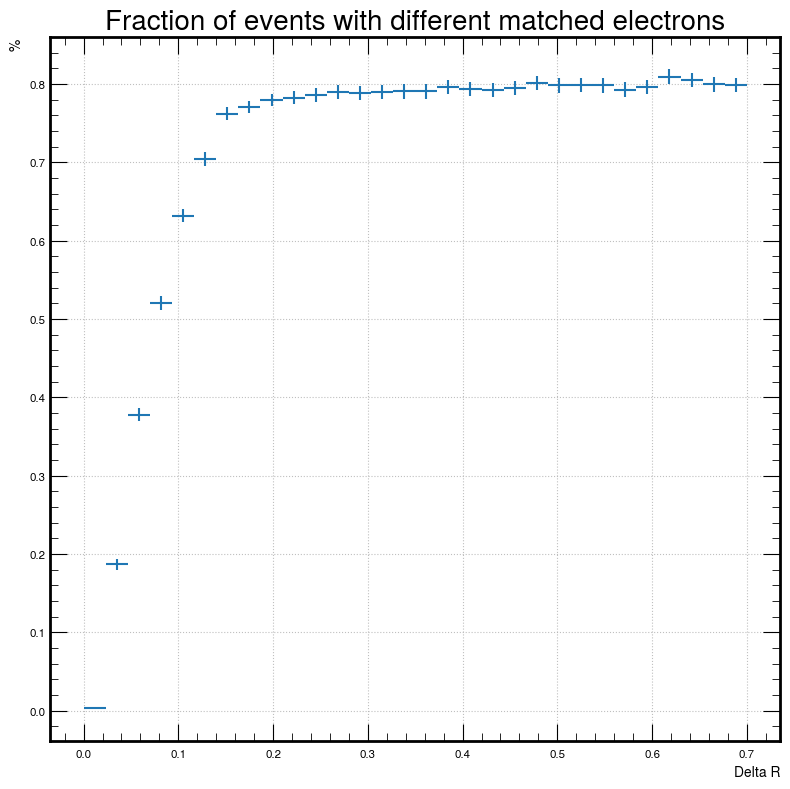

In [24]:
def fraction_onemissing_ele_index_vs_deltaR(num_intervals):
    deltaR_max = 0.7
    deltaR_values, y = np.linspace(0, deltaR_max, num_intervals + 1, retstep=True)

    fraction_list = []
    yer = []

    for i in range(len(deltaR_values) - 1):
        lower_bound = deltaR_values[i]
        upper_bound = deltaR_values[i + 1]
        #print('interval=[',lower_bound,upper_bound,']')
        mask =  (different_ele_events['deltaR'] > lower_bound) &  (different_ele_events['deltaR'] <= upper_bound)
        mask2 = (grouped_deltas['deltaR'] > lower_bound) & (grouped_deltas['deltaR'] <= upper_bound)

        n1 = len(different_ele_events[mask])
        #print('n1: ',n1)
        ntot = len(grouped_deltas[mask2])
        #print('ntot: ',ntot)
        if ntot == 0:
            ntot = 1
        fraction = n1 / ntot
        fraction_list.append(fraction)
        yer.append(np.sqrt(n1 + n1**2 / ntot) / ntot)

    plt.figure(figsize=(8,8), dpi=100)  # Larger figsize
    plt.errorbar(deltaR_values[:-1] + y / 2, fraction_list, xerr=np.ones(num_intervals) * y / 2, yerr=yer, fmt='none')
    #plt.scatter(deltaR_values[:-1] + y / 2, fraction_list)
    plt.xlabel('Delta R')
    plt.ylabel('%') 
    plt.title('Fraction of events with different matched electrons', fontsize=20)  
    plt.grid(True)
    plt.tight_layout()
    #plt.savefig('plots/different_ele_deltaR.png')
    plt.show()

num_intervals = 30
fraction_onemissing_ele_index_vs_deltaR(num_intervals)


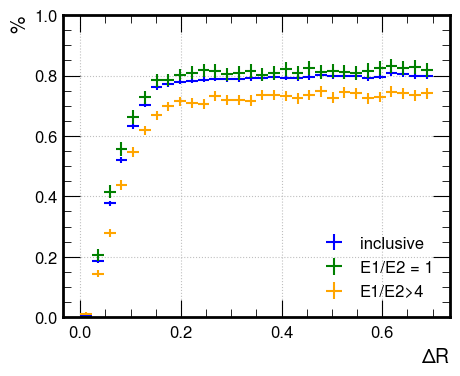

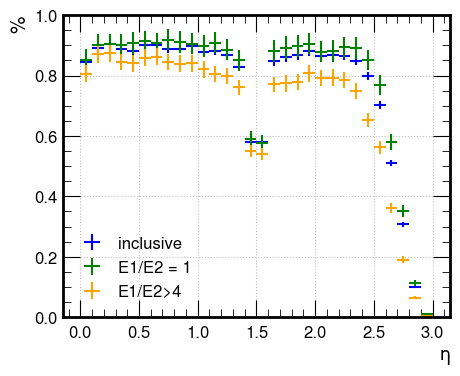

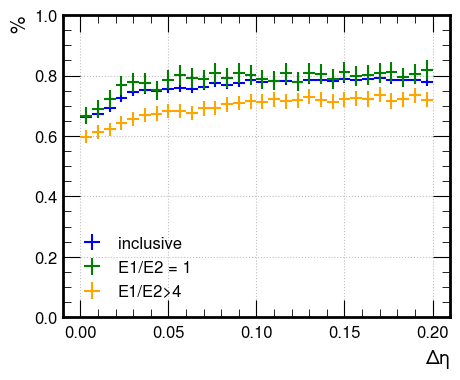

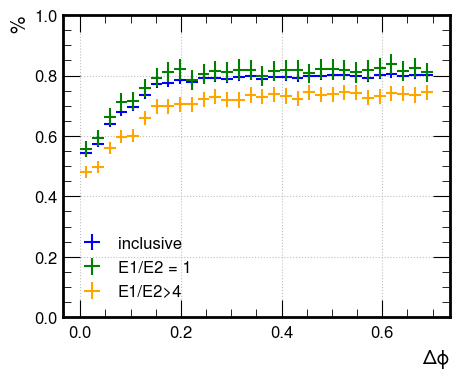

In [26]:
mask_e1 =(energy_ratio>0.8)&(energy_ratio<1.2)
mask_e3 =energy_ratio>3

def fraction_different_ele_index_vs_deltaR(num_intervals,different_ele_events,deltaR_max,col,xlab,a):
    deltaR_values, y = np.linspace(0, deltaR_max, num_intervals + 1, retstep=True)

    masks = [(1,1), 
             ((different_ele_events.energy_ratio > 0.8)&(different_ele_events.energy_ratio < 1.2),
              (grouped_deltas.energy_ratio > 0.8)&(grouped_deltas.energy_ratio < 1.2)),
             ((different_ele_events.energy_ratio > 4), (grouped_deltas.energy_ratio > 4))]

    names = ["inclusive", "E1/E2 = 1", "E1/E2>4"]
    colors= ["blue", "green", "orange"]
    plt.figure(figsize=(5,4), dpi=100)  # Larger figsize
    for (mask_same, mask_all), name, color in zip(masks, names, colors):
        
        fraction_list = []
        yer = []
    
        # mask_en_same = (different_ele_events.energy_ratio > 0.8)&(different_ele_events.energy_ratio > 1.2)
        # mask_en_same2 = (different_ele_events.energy_ratio > 3)
       #for mask_en in [True, mask_en_same, mask_en_same2)
        for i in range(len(deltaR_values) - 1):
            lower_bound = deltaR_values[i]
            upper_bound = deltaR_values[i + 1]
            #print('interval=[',lower_bound,upper_bound,']')
            mask = (different_ele_events[col] > lower_bound) & (different_ele_events[col] <= upper_bound) & mask_same
            mask2 = (grouped_deltas[col] > lower_bound) & (grouped_deltas[col] <= upper_bound) & mask_all
            
    
            n1 = len(different_ele_events[mask])
            #print('n1: ',n1)
            ntot = len(grouped_deltas[mask2])
            #print('ntot: ',ntot)
            if ntot == 0:
                ntot = 1
            fraction = n1 / ntot
            fraction_list.append(fraction)
            yer.append(np.sqrt(n1 + n1**2 / ntot) / ntot)
    
       
        plt.errorbar(deltaR_values[:-1] + y / 2, fraction_list, xerr=np.ones(num_intervals) * y / 2, yerr=yer, fmt='none',
                    label=name, c=color)
        #plt.scatter(deltaR_values[:-1] + y / 2, fraction_list)
    plt.xlabel( xlab,fontsize=14)
    plt.ylabel('%',fontsize=14) 
    plt.ylim(0, 1)
    #plt.title('Fraction of events with different matched electrons for MSC', fontsize=16)  
    plt.grid(True)
    plt.tick_params(axis='both', which='major', labelsize=12)
    
    
    plt.legend(loc=a,fontsize=12)
    name='plotsM/different_ele_'+col+'.pdf'
    plt.savefig(name)
    #plt.tight_layout()
    plt.show()

num_intervals = 30
fraction_different_ele_index_vs_deltaR(num_intervals,different_ele_events, 0.7, 'deltaR', '$\Delta R$','lower right')
fraction_different_ele_index_vs_deltaR(num_intervals,different_ele_events, 3, 'eta_mean', '$\eta$','lower left')
fraction_different_ele_index_vs_deltaR(num_intervals,different_ele_events, 0.2, 'deltaEta','$\Delta \eta$','lower left')
fraction_different_ele_index_vs_deltaR(num_intervals,different_ele_events, 0.7, 'deltaPhi','$\Delta \phi$','lower left')

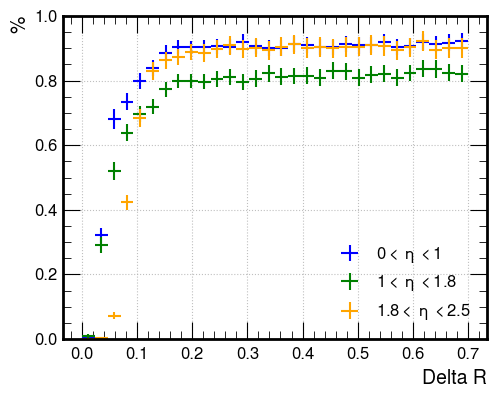

In [27]:
mask_e1 =(energy_ratio>0.8)&(energy_ratio<1.2)
mask_e3 =energy_ratio>3

def fraction_different_ele_index_vs_deltaR(num_intervals,different_ele_events):
    deltaR_max = 0.7
    deltaR_values, y = np.linspace(0, deltaR_max, num_intervals + 1, retstep=True)

    mask_e1_g = (grouped_deltas.eta_mean<1)&(grouped_deltas.eta_mean>0)
    mask_e3_g =(grouped_deltas.eta_mean<1.8)&(grouped_deltas.eta_mean>1)
    mask_e0_g =(grouped_deltas.eta_mean<2.5)&(grouped_deltas.eta_mean>1.8)
    mask_e1 = (different_ele_events.eta_mean<1)&(different_ele_events.eta_mean>0)
    mask_e3 =(different_ele_events.eta_mean<1.8)&(different_ele_events.eta_mean>1)
    mask_e0 =(different_ele_events.eta_mean<2.5)&(different_ele_events.eta_mean>1.8)
    masks = [(mask_e1,mask_e1_g),
             (mask_e3,mask_e3_g),
             (mask_e0,mask_e0_g)]
    
    names = ['$0< \; \eta \; <1$', '$1< \; \eta \; <1.8$','$1.8< \; \eta \; <2.5$']
    colors= ["blue", "green", "orange"]
    plt.figure(figsize=(5,4), dpi=100)  # Larger figsize
    for (mask_same, mask_all), name, color in zip(masks, names, colors):
        
        fraction_list = []
        yer = []
    
        # mask_en_same = (different_ele_events.energy_ratio > 0.8)&(different_ele_events.energy_ratio > 1.2)
        # mask_en_same2 = (different_ele_events.energy_ratio > 3)
       #for mask_en in [True, mask_en_same, mask_en_same2)
        for i in range(len(deltaR_values) - 1):
            lower_bound = deltaR_values[i]
            upper_bound = deltaR_values[i + 1]
            #print('interval=[',lower_bound,upper_bound,']')
            mask = (different_ele_events['deltaR'] > lower_bound) & (different_ele_events['deltaR'] <= upper_bound) & mask_same
            mask2 = (grouped_deltas['deltaR'] > lower_bound) & (grouped_deltas['deltaR'] <= upper_bound) & mask_all
            
    
            n1 = len(different_ele_events[mask])
            #print('n1: ',n1)
            ntot = len(grouped_deltas[mask2])
            #print('ntot: ',ntot)
            if ntot == 0:
                ntot = 1
            fraction = n1 / ntot
            fraction_list.append(fraction)
            yer.append(np.sqrt(n1 + n1**2 / ntot) / ntot)
    
       
        plt.errorbar(deltaR_values[:-1] + y / 2, fraction_list, xerr=np.ones(num_intervals) * y / 2, yerr=yer, fmt='none',
                    label=name, c=color)
        #plt.scatter(deltaR_values[:-1] + y / 2, fraction_list)
    plt.xlabel('Delta R',fontsize=14)
    plt.ylabel('%',fontsize=14) 
    plt.ylim(0, 1)
    #plt.title('Fraction of events with different matched electrons for MSC', fontsize=16)  
    plt.grid(True)
    plt.tight_layout()
    
    plt.tick_params(axis='both', which='major', labelsize=12)
   
    plt.legend(loc="lower right",fontsize=12) 
    plt.savefig('plotsM/different_ele_detlar_eta.pdf')
    plt.show()

num_intervals = 30
fraction_different_ele_index_vs_deltaR(num_intervals,different_ele_events)


In [28]:
#fraction_vs_deltaR(num_intervals,different_ele_events,'genparticle is ele matched but to a different ele')'

## One matched the other not

In [29]:
#fraction_vs_deltaR(num_intervals,onemissing_events,'One is matched and the other not')

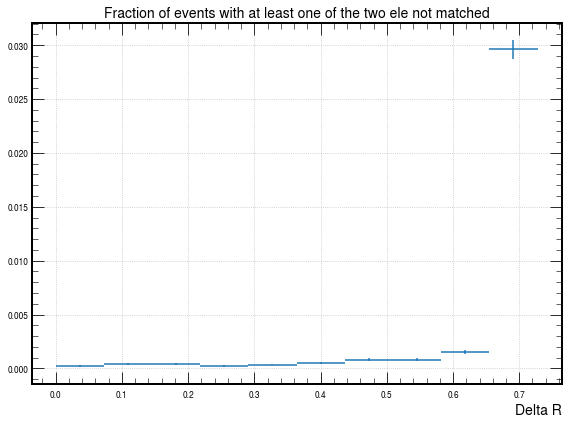

In [30]:
def nonelematched_deltar(num_intervals):
    deltaR_max = onemissing_events['deltaR'].max()
    deltaR_values, y = np.linspace(0, deltaR_max, num_intervals + 1, retstep=True)

    fraction_list = []
    yer = []

    for i in range(len(deltaR_values) - 1):
        lower_bound = deltaR_values[i]
        upper_bound = deltaR_values[i + 1]
        mask2 = (grouped_deltas['deltaR'] > lower_bound) & (grouped_deltas['deltaR'] <= upper_bound)
        dr_group=grouped_deltas[mask2 & onemissing_events_mask]
        
        ntot = len(grouped_deltas[mask2])
        n1 = len(dr_group)
        
        if ntot == 0:
            ntot = 1
        fraction = n1 / ntot
        fraction_list.append(fraction)
        yer.append(np.sqrt(n1 + n1**2 / ntot) / ntot)

    plt.figure(figsize=(8,6))  # Larger figsize
    plt.errorbar(deltaR_values[:-1] + y / 2, fraction_list, xerr=np.ones(num_intervals) * y / 2, yerr=yer, fmt='none')
    #plt.scatter(deltaR_values[:-1] + y / 2, fraction_list)
    plt.xlabel('Delta R', fontsize=14)
    plt.title('Fraction of events with at least one of the two ele not matched', fontsize=14) 
    #plt.title('Fraction of events with same ele_index vs. Delta R', fontsize=16)  
    plt.grid(True)
    plt.tight_layout()
    #plt.savefig('plots/onemissing_deltaR.png')
    plt.show()

num_intervals = 10
nonelematched_deltar(num_intervals)


/tmp/ipykernel_657/1852895047.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  onemissing_events['non_matched_calo_energy'] = onemissing_events.apply(


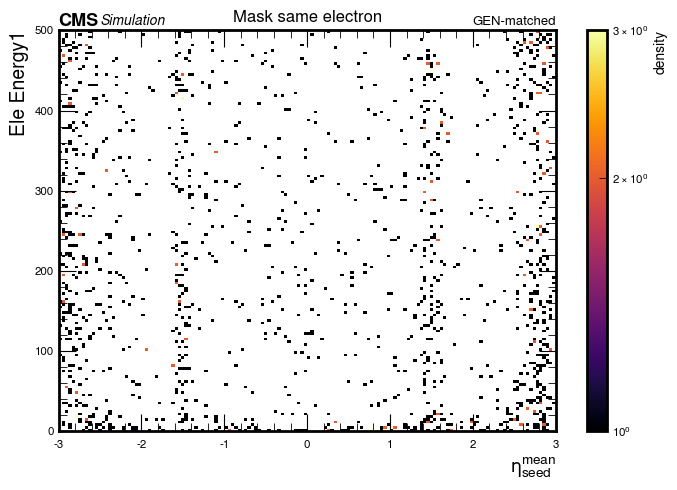

In [31]:
mask_nonmatched=(onemissing_events['ele_matched2']==False)&(onemissing_events['ele_matched1']==False)
onemissing_events['non_matched_calo_energy'] = onemissing_events.apply(
    lambda row: row['calo_energy2'] if row['ele_matched1'] else row['calo_energy1'],
    axis=1
)

fig, ax = plt.subplots(1,1,dpi=100, figsize=(7, 5))

A,xedges,yedges  = np.histogram2d(onemissing_events.eta_mean ,onemissing_events.non_matched_calo_energy,bins=(150, 150), range=((-3,3),(0,500)))

s = 1#np.expand_dims(np.sum(A, axis=-1), axis=1)
a = A/s
X, Y = np.meshgrid(xedges, yedges)
I = ax.pcolormesh(X, Y, a.T, norm=LogNorm(), cmap="inferno")

fig.colorbar(I, ax=ax, label="density")
ax.set_xlabel("$\eta^{mean}_{seed}$", fontsize=14)
ax.set_ylabel("Ele Energy1", fontsize=14)
plt.title('Mask same electron')
hep.cms.label(llabel="Simulation", rlabel="GEN-matched", loc=0, ax=ax)
plt.tight_layout()
plt.savefig('plots/eleet1_eta.png')

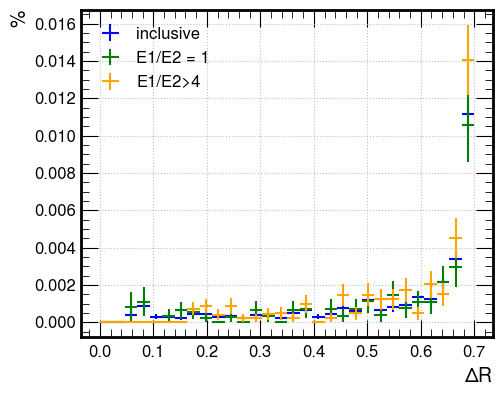

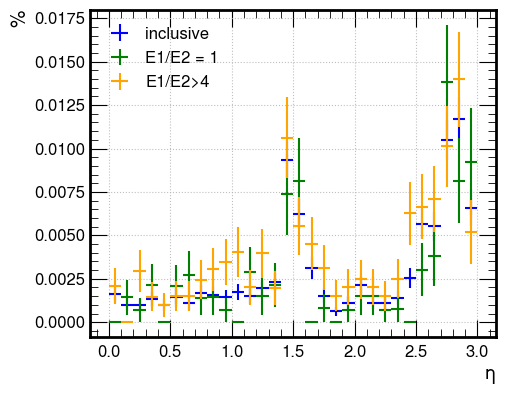

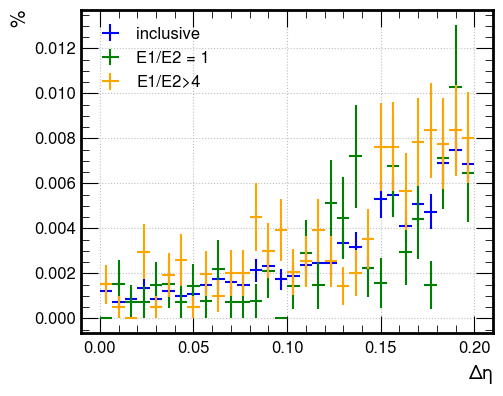

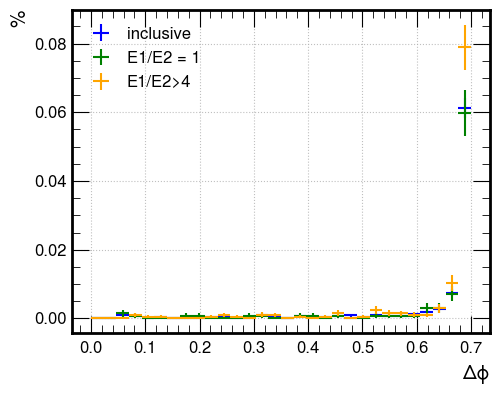

In [33]:
mask_e1 =(energy_ratio>0.8)&(energy_ratio<1.2)
mask_e3 =energy_ratio>3

def fraction_onemissing_ele_index_vs_deltaR(num_intervals,deltaR_max,col,xlab):
    deltaR_values, y = np.linspace(0, deltaR_max, num_intervals + 1, retstep=True)

    masks = [(1,1), 
             ((onemissing_events.energy_ratio > 0.8)&(onemissing_events.energy_ratio < 1.2),
              (grouped_deltas.energy_ratio > 0.8)&(grouped_deltas.energy_ratio < 1.2)),
             ((onemissing_events.energy_ratio > 4), (grouped_deltas.energy_ratio > 4))]

    names = ["inclusive", "E1/E2 = 1", "E1/E2>4"]
    colors= ["blue", "green", "orange"]
    plt.figure(figsize=(5,4), dpi=100)  # Larger figsize
    for (mask_same, mask_all), name, color in zip(masks, names, colors):
        
        fraction_list = []
        yer = []
    
        # mask_en_same = (onemissing_events.energy_ratio > 0.8)&(onemissing_events.energy_ratio > 1.2)
        # mask_en_same2 = (onemissing_events.energy_ratio > 3)
       #for mask_en in [True, mask_en_same, mask_en_same2)
        for i in range(len(deltaR_values) - 1):
            lower_bound = deltaR_values[i]
            upper_bound = deltaR_values[i + 1]
            #print('interval=[',lower_bound,upper_bound,']')
            mask = (onemissing_events[col] > lower_bound) & (onemissing_events[col] <= upper_bound) & mask_same
            mask2 = (grouped_deltas[col] > lower_bound) & (grouped_deltas[col] <= upper_bound) & mask_all
            
    
            n1 = len(onemissing_events[mask])
            #print('n1: ',n1)
            ntot = len(grouped_deltas[mask2])
            #print('ntot: ',ntot)
            if ntot == 0:
                ntot = 1
            fraction = n1 / ntot
            fraction_list.append(fraction)
            yer.append(np.sqrt(n1 + n1**2 / ntot) / ntot)
    
       
        plt.errorbar(deltaR_values[:-1] + y / 2, fraction_list, xerr=np.ones(num_intervals) * y / 2, yerr=yer, fmt='none',
                    label=name, c=color)
        #plt.scatter(deltaR_values[:-1] + y / 2, fraction_list)
    plt.xlabel(xlab,fontsize=14)
    plt.ylabel('%',fontsize=14) 
    #plt.ylim(0, 1)
    #plt.title('Fraction of events with one of the electrons not matched', fontsize=20)  
    plt.grid(True)
    plt.tight_layout()
    
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.legend(loc='upper left',fontsize=12)
    name='plotsM/onemissing_'+col+'.pdf'
    plt.savefig(name)
    plt.show()

num_intervals = 30
fraction_onemissing_ele_index_vs_deltaR(num_intervals, 0.7, 'deltaR', '$\Delta R$')
fraction_onemissing_ele_index_vs_deltaR(num_intervals, 3, 'eta_mean', '$\eta$')
fraction_onemissing_ele_index_vs_deltaR(num_intervals, 0.2, 'deltaEta','$\Delta \eta$')
fraction_onemissing_ele_index_vs_deltaR(num_intervals, 0.7, 'deltaPhi','$\Delta \phi$')

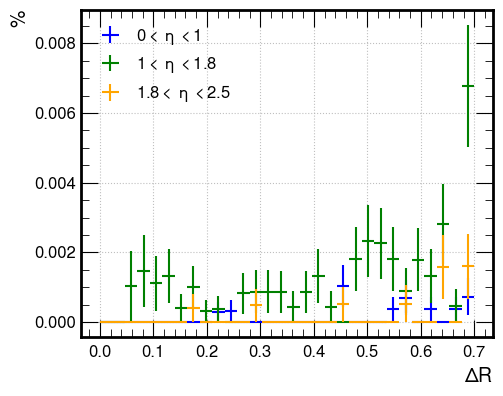

In [38]:
mask_e1 =(energy_ratio>0.8)&(energy_ratio<1.2)
mask_e3 =energy_ratio>3

def fraction_onemissing_ele_index_vs_deltaR(num_intervals,different_ele_events):
    deltaR_max = 0.7
    deltaR_values, y = np.linspace(0, deltaR_max, num_intervals + 1, retstep=True)

    mask_e1_g = (grouped_deltas.eta_mean<1)&(grouped_deltas.eta_mean>0)
    mask_e3_g =(grouped_deltas.eta_mean<1.8)&(grouped_deltas.eta_mean>1)
    mask_e0_g =(grouped_deltas.eta_mean<2.5)&(grouped_deltas.eta_mean>1.8)
    mask_e1 = (different_ele_events.eta_mean<1)&(different_ele_events.eta_mean>0)
    mask_e3 =(different_ele_events.eta_mean<1.8)&(different_ele_events.eta_mean>1)
    mask_e0 =(different_ele_events.eta_mean<2.5)&(different_ele_events.eta_mean>1.8)
    
    masks = [(mask_e1,mask_e1_g),
             (mask_e3,mask_e3_g),
             (mask_e0,mask_e0_g)]
    
    names = ['$0< \; \eta \; <1$', '$1< \; \eta \; <1.8$','$1.8< \; \eta \; <2.5$']
    colors= ["blue", "green", "orange"]
    plt.figure(figsize=(5,4), dpi=100)  # Larger figsize
    for (mask_same, mask_all), name, color in zip(masks, names, colors):
        
        fraction_list = []
        yer = []
    
        # mask_en_same = (onemissing_events.energy_ratio > 0.8)&(onemissing_events.energy_ratio > 1.2)
        # mask_en_same2 = (onemissing_events.energy_ratio > 3)
       #for mask_en in [True, mask_en_same, mask_en_same2)
        for i in range(len(deltaR_values) - 1):
            lower_bound = deltaR_values[i]
            upper_bound = deltaR_values[i + 1]
            #print('interval=[',lower_bound,upper_bound,']')
            mask = (onemissing_events['deltaR'] > lower_bound) & (onemissing_events['deltaR'] <= upper_bound) & mask_same
            mask2 = (grouped_deltas['deltaR'] > lower_bound) & (grouped_deltas['deltaR'] <= upper_bound) & mask_all
            
    
            n1 = len(onemissing_events[mask])
            #print('n1: ',n1)
            ntot = len(grouped_deltas[mask2])
            #print('ntot: ',ntot)
            if ntot == 0:
                ntot = 1
            fraction = n1 / ntot
            fraction_list.append(fraction)
            yer.append(np.sqrt(n1 + n1**2 / ntot) / ntot)
    
       
        plt.errorbar(deltaR_values[:-1] + y / 2, fraction_list, xerr=np.ones(num_intervals) * y / 2, yerr=yer, fmt='none',
                    label=name, c=color)
        #plt.scatter(deltaR_values[:-1] + y / 2, fraction_list)
    plt.xlabel('$\Delta R$',fontsize=14)
    plt.ylabel('%',fontsize=14) 
    #plt.ylim(0, 1)
    #plt.title('Fraction of events with one of the electrons not matched for MSC', fontsize=16)  
    plt.grid(True)
    plt.tight_layout()
    
    plt.tick_params(axis='both', which='major', labelsize=12)
    
    plt.legend(loc='upper left',fontsize=12)
    plt.savefig('plotsM/onemissing_deltaR_eta.pdf')
    plt.show()

num_intervals = 30
fraction_onemissing_ele_index_vs_deltaR(num_intervals,onemissing_events)


## mask lowest energy

In [39]:
grouped_deltas['calo_energy_min'] = grouped_deltas[['calo_energy1', 'calo_energy2']].min(axis=1)

same_ele_events['calo_energy_min'] = same_ele_events[['calo_energy1', 'calo_energy2']].min(axis=1)
print(same_ele_events[['calo_energy1', 'calo_energy2','calo_energy_min']])

        calo_energy1  calo_energy2  calo_energy_min
8          74.392734     75.991481        74.392734
11        167.584058     21.289917        21.289917
14        381.190756    447.693415       381.190756
15        268.397434    159.325919       159.325919
20        488.966629    164.659506       164.659506
...              ...           ...              ...
482970    341.966732    130.541698       130.541698
482971    483.378708     59.240714        59.240714
482975    483.120033     80.723670        80.723670
482980    345.724521    465.295495       345.724521
482984    466.668523    219.625320       219.625320

[83980 rows x 3 columns]


/tmp/ipykernel_657/2192947528.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  same_ele_events['calo_energy_min'] = same_ele_events[['calo_energy1', 'calo_energy2']].min(axis=1)


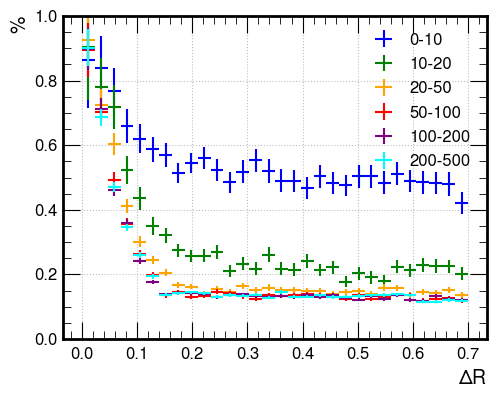

In [40]:
mask_e1 =(energy_ratio>0.8)&(energy_ratio<1.2)
mask_e3 =energy_ratio>3

def fraction_same_ele_index_vs_deltaR(num_intervals):
    deltaR_max = 0.7
    deltaR_values, y = np.linspace(0, deltaR_max, num_intervals + 1, retstep=True)

    intervals = [(0, 10), (10, 20), (20, 50), (50, 100), (100, 200), (200, 500)]


    masks = []
    for interval in intervals:
        mask_same_ele = (same_ele_events.calo_energy_min > interval[0]) & (same_ele_events.calo_energy_min <= interval[1])
        mask_grouped = (grouped_deltas.calo_energy_min > interval[0]) & (grouped_deltas.calo_energy_min <= interval[1])
        masks.append((mask_same_ele, mask_grouped))

    names = [f"{interval[0]}-{interval[1]}" for interval in intervals]


    colors = ["blue", "green", "orange", "red", "purple", "cyan"]
    plt.figure(figsize=(5,4), dpi=100)  # Larger figsize
    for (mask_same, mask_all), name, color in zip(masks, names, colors):
        
        fraction_list = []
        yer = []
    
        # mask_en_same = (same_ele_events.energy_ratio > 0.8)&(same_ele_events.energy_ratio > 1.2)
        # mask_en_same2 = (same_ele_events.energy_ratio > 3)
       #for mask_en in [True, mask_en_same, mask_en_same2)
        for i in range(len(deltaR_values) - 1):
            lower_bound = deltaR_values[i]
            upper_bound = deltaR_values[i + 1]
            #print('interval=[',lower_bound,upper_bound,']')
            mask = (same_ele_events['deltaR'] > lower_bound) & (same_ele_events['deltaR'] <= upper_bound) & mask_same
            mask2 = (grouped_deltas['deltaR'] > lower_bound) & (grouped_deltas['deltaR'] <= upper_bound) & mask_all
            
    
            n1 = len(same_ele_events[mask])
            #print('n1: ',n1)
            ntot = len(grouped_deltas[mask2])
            #print('ntot: ',ntot)
            if ntot == 0:
                ntot = 1
            fraction = n1 / ntot
            fraction_list.append(fraction)
            yer.append(np.sqrt(n1 + n1**2 / ntot) / ntot)
    
       
        plt.errorbar(deltaR_values[:-1] + y / 2, fraction_list, xerr=np.ones(num_intervals) * y / 2, yerr=yer, fmt='none',
                    label=name, c=color)
        #plt.scatter(deltaR_values[:-1] + y / 2, fraction_list)
    plt.xlabel('$\Delta R$',fontsize=14)
    plt.ylabel('%',fontsize=14) 
    plt.ylim(0, 1)
    #plt.title('Fraction of events with single electron matched for MSC', fontsize=16)  
    plt.grid(True)
    plt.tight_layout()
    
    plt.tick_params(axis='both', which='major', labelsize=12)
    
    plt.legend(fontsize=12)
    plt.savefig('plotsM/sameele_deltaR_E.pdf')
    plt.show()

num_intervals = 30
fraction_same_ele_index_vs_deltaR(num_intervals)


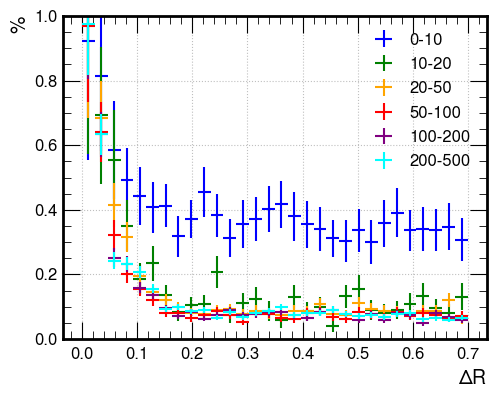

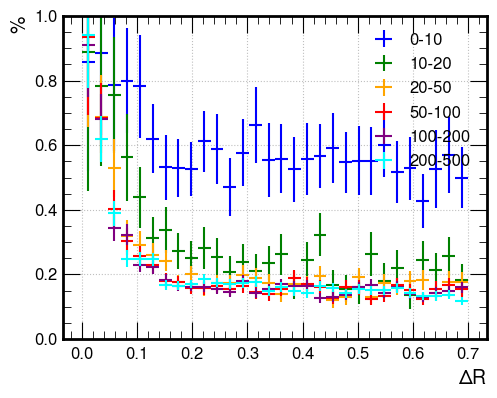

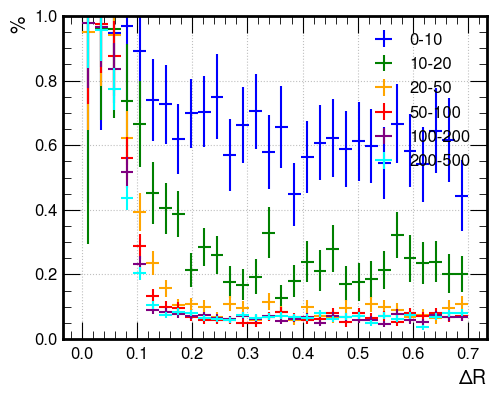

In [42]:
mask_e1 =(energy_ratio>0.8)&(energy_ratio<1.2)
mask_e3 =energy_ratio>3

def fraction_same_ele_index_vs_deltaR(num_intervals,same_ele_events,grouped_deltas,tit):
    deltaR_max = 0.7
    deltaR_values, y = np.linspace(0, deltaR_max, num_intervals + 1, retstep=True)

    intervals = [(0, 10), (10, 20), (20, 50), (50, 100), (100, 200), (200, 500)]


    masks = []
    for interval in intervals:
        mask_same_ele = (same_ele_events.calo_energy_min > interval[0]) & (same_ele_events.calo_energy_min <= interval[1])
        mask_grouped = (grouped_deltas.calo_energy_min > interval[0]) & (grouped_deltas.calo_energy_min <= interval[1])
        masks.append((mask_same_ele, mask_grouped))

    names = [f"{interval[0]}-{interval[1]}" for interval in intervals]


    colors = ["blue", "green", "orange", "red", "purple", "cyan"]
    plt.figure(figsize=(5,4), dpi=100)  # Larger figsize
    for (mask_same, mask_all), name, color in zip(masks, names, colors):
        
        fraction_list = []
        yer = []
    
        # mask_en_same = (same_ele_events.energy_ratio > 0.8)&(same_ele_events.energy_ratio > 1.2)
        # mask_en_same2 = (same_ele_events.energy_ratio > 3)
       #for mask_en in [True, mask_en_same, mask_en_same2)
        for i in range(len(deltaR_values) - 1):
            lower_bound = deltaR_values[i]
            upper_bound = deltaR_values[i + 1]
            #print('interval=[',lower_bound,upper_bound,']')
            mask = (same_ele_events['deltaR'] > lower_bound) & (same_ele_events['deltaR'] <= upper_bound) & mask_same
            mask2 = (grouped_deltas['deltaR'] > lower_bound) & (grouped_deltas['deltaR'] <= upper_bound) & mask_all
            
    
            n1 = len(same_ele_events[mask])
            #print('n1: ',n1)
            ntot = len(grouped_deltas[mask2])
            #print('ntot: ',ntot)
            if ntot == 0:
                ntot = 1
            fraction = n1 / ntot
            fraction_list.append(fraction)
            yer.append(np.sqrt(n1 + n1**2 / ntot) / ntot)
    
       
        plt.errorbar(deltaR_values[:-1] + y / 2, fraction_list, xerr=np.ones(num_intervals) * y / 2, yerr=yer, fmt='none',
                    label=name, c=color)
        #plt.scatter(deltaR_values[:-1] + y / 2, fraction_list)
    plt.xlabel('$\Delta R$',fontsize=14)
    plt.ylabel('%',fontsize=14) 
    plt.ylim(0, 1)
    #plt.title('Fraction of events with single electron matched '+tit+' for MSC', fontsize=16)  
    plt.grid(True)
    plt.tight_layout()
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.legend(fontsize=12)
    name='plotsM/sameele_deltaR_E_'+tit+'.pdf'
    plt.savefig(name)
    plt.show()

    
    
    
    
    
    
mask_e1_g = (grouped_deltas.eta_mean<1)&(grouped_deltas.eta_mean>0)
mask_e3_g =(grouped_deltas.eta_mean<1.8)&(grouped_deltas.eta_mean>1)
mask_e0_g =(grouped_deltas.eta_mean<2.5)&(grouped_deltas.eta_mean>1.8)
mask_e1 = (same_ele_events.eta_mean<1)&(same_ele_events.eta_mean>0)
mask_e3 =(same_ele_events.eta_mean<1.8)&(same_ele_events.eta_mean>1)
mask_e0 =(same_ele_events.eta_mean<2.5)&(same_ele_events.eta_mean>1.8)
num_intervals = 30
fraction_same_ele_index_vs_deltaR(num_intervals,same_ele_events[mask_e1],grouped_deltas[mask_e1_g],'eta from zero to 1')
fraction_same_ele_index_vs_deltaR(num_intervals,same_ele_events[mask_e3],grouped_deltas[mask_e3_g],'eta from 1 to 1.8')
fraction_same_ele_index_vs_deltaR(num_intervals,same_ele_events[mask_e0],grouped_deltas[mask_e0_g],'eta from 1.8 to 2.5')


## Mustacchio

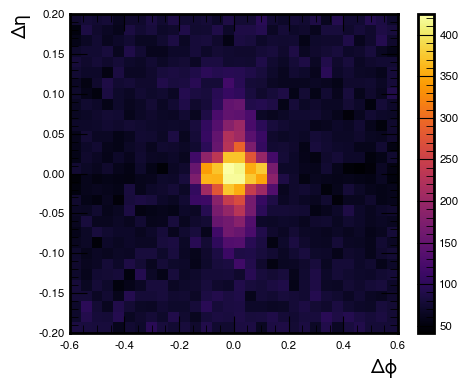

In [50]:
def delta_eta_phi_same_ele(same_ele_events,MD):
    fig, ax = plt.subplots(1,1,dpi=100, figsize=(5,4))

    A,xedges,yedges  = np.histogram2d(same_ele_events.deltaPhi ,same_ele_events.deltaEta,bins=(30,30),range=((-0.6,0.6),(-0.2,0.2)))

    s = 1#np.expand_dims(np.sum(A, axis=-1), axis=1)
    a = A/s
    # Define a custom colormap with white for zero values
    cmap = plt.cm.viridis
    cmap.set_bad(color='white')

    # Mask the array where values are zero
    a_masked = np.ma.masked_where(a == 0, a)

    X, Y = np.meshgrid(xedges, yedges)
    I = ax.pcolormesh(X, Y, a_masked.T, cmap='inferno')

    fig.colorbar(I, ax=ax,norm=LogNorm())
    ax.set_xlabel("$\Delta \phi$", fontsize=14)
    ax.set_ylabel("$\Delta \eta$", fontsize=14)
    #plt.title('Mask same electron'+MD)
    #hep.cms.label(llabel="Simulation", rlabel="GEN-matched", loc=0, ax=ax)
    plt.tight_layout()
    plt.savefig('plotsM/e2_eta.pdf')
    
delta_eta_phi_same_ele(same_ele_events,' Mustache')
#delta_eta_phi_same_ele(same_ele_events[pho_false],' pho not matched Mustache')

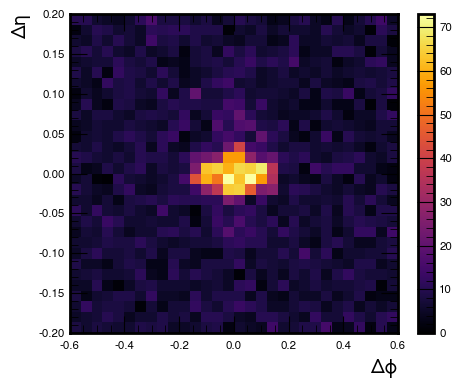

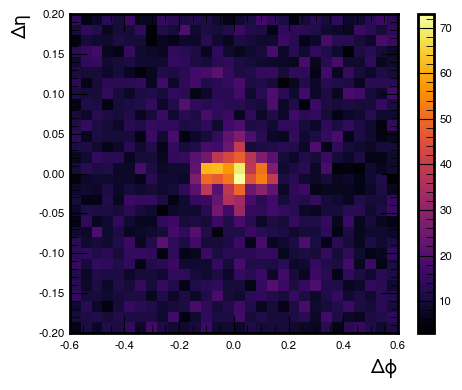

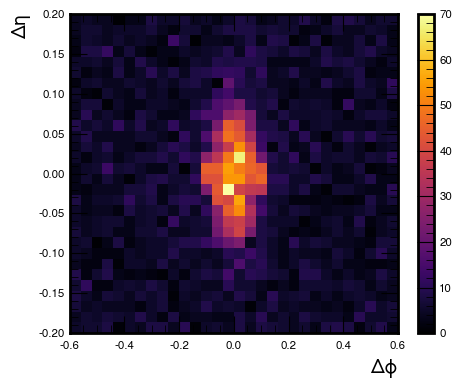

In [55]:
def delta_eta_phi_masketa(same_ele_events,MD):
    mask_e1 = (same_ele_events.eta_mean<1)&(same_ele_events.eta_mean>0)
    mask_e3 =(same_ele_events.eta_mean<1.8)&(same_ele_events.eta_mean>1)
    mask_e0 =(same_ele_events.eta_mean<2.5)&(same_ele_events.eta_mean>1.8)

    def create_hist2d_plot(mask, title, filename):
        fig, ax = plt.subplots(1, 1, dpi=100, figsize=(5,4))

        A, xedges, yedges = np.histogram2d(
            same_ele_events.deltaPhi[mask], 
            same_ele_events.deltaEta[mask], 
            bins=(30,30), 
            range=((-0.6, 0.6), (-0.2, 0.2))
        )

        s = 1  # np.expand_dims(np.sum(A, axis=-1), axis=1)
        a = A / s
        X, Y = np.meshgrid(xedges, yedges)
        I = ax.pcolormesh(X, Y, a.T, cmap="inferno")

        fig.colorbar(I, ax=ax, norm=LogNorm())
        ax.set_xlabel("$\Delta \phi$", fontsize=14)
        ax.set_ylabel("$\Delta \eta$", fontsize=14)
        #plt.title(title)
        # Placeholder for hep.cms.label - comment out as hep is not available in this environment
        # hep.cms.label(llabel="Simulation", rlabel="GEN-matched", loc=0, ax=ax)
        plt.tight_layout()
        plt.savefig(filename)
        plt.show()

    # Create and save plots for each mask
    create_hist2d_plot(mask_e1, 'Mask eta_mean < 1 and eta_mean > 0'+MD, 'plotsM/eta_mean_0_1.pdf')
    create_hist2d_plot(mask_e3, 'Mask eta_mean < 1.8 and eta_mean > 1' +MD, 'plotsM/eta_mean_1_1.8.pdf')
    create_hist2d_plot(mask_e0, 'Mask eta_mean < 2.5 and eta_mean > 1.8'+MD, 'plotsM/eta_mean_1.8_2.5.pdf')

delta_eta_phi_masketa(same_ele_events,' Mustache')

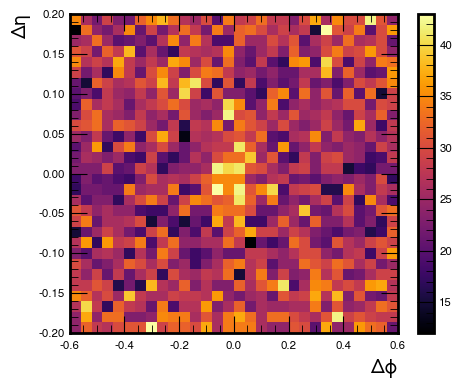

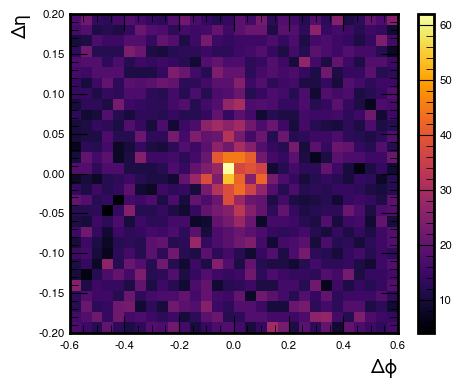

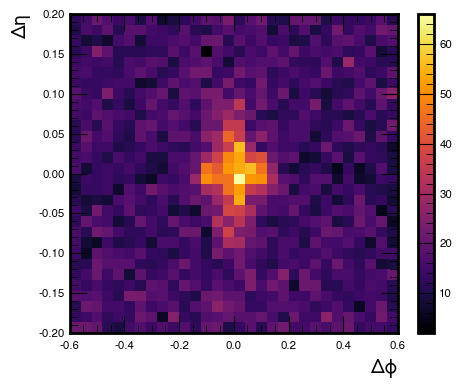

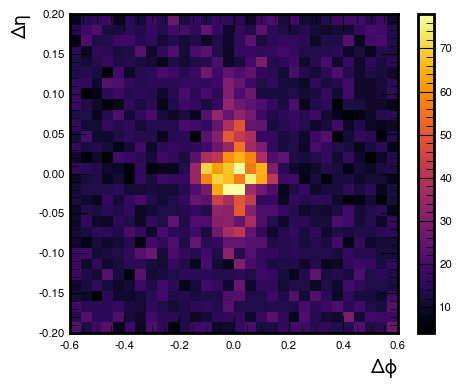

In [54]:
def delta_eta_phi_etmask(same_ele_events,MD):
    intervals = [(0, 200), (200, 300), (300, 400), (400, 500)]
    masks = []

    for interval in intervals:
        mask_same_ele = (same_ele_events.ele_et1 > interval[0]) & (same_ele_events.ele_et1 <= interval[1])
        masks.append(mask_same_ele)

    names = [f"{interval[0]}-{interval[1]}" for interval in intervals]


    # Define function to create hist2d plots with titles for new masks
    def create_hist2d_plot(mask, title, filename):
        fig, ax = plt.subplots(1, 1, dpi=100, figsize=(5, 4))

        A, xedges, yedges = np.histogram2d(
            same_ele_events.deltaPhi[mask], 
            same_ele_events.deltaEta[mask], 
            bins=(30, 30), 
            range=((-0.6, 0.6), (-0.2, 0.2))
        )

        s = 1  # np.expand_dims(np.sum(A, axis=-1), axis=1)
        a = A / s
        X, Y = np.meshgrid(xedges, yedges)
        I = ax.pcolormesh(X, Y, a.T, cmap="inferno")

        fig.colorbar(I, ax=ax, norm=LogNorm())
        ax.set_xlabel("$\Delta \phi$", fontsize=14)
        ax.set_ylabel("$\Delta \eta$", fontsize=14)
        #plt.title(title,fontsize=14)
        # Placeholder for hep.cms.label - comment out as hep is not available in this environment
        # hep.cms.label(llabel="Simulation", rlabel="GEN-matched", loc=0, ax=ax)
        plt.tight_layout()
        #plt.savefig(filename)
        plt.show()

    # Create and save plots for each interval mask
    for mask_same_ele, name in zip(masks, names):
        create_hist2d_plot(mask_same_ele, f'Mask ele ET {name} (same_ele_events)' +MD, f'plotsM/same_ele_{name}.pdf')
delta_eta_phi_etmask(same_ele_events,' Mustache')